In [ ]:
import re
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    f1_score
)

In [ ]:
nlp = spacy.load("en_core_web_sm")

stop_words = stopwords.words('english')
stop_words.extend([
    "product","amazon","review","reviews","purchase","purchased","buy","bought",
    "item","items","order","ordered","shipping","delivery","packaging","seller",
    "customer","service","price","prices","brand","brands","store","stores"
])

preserve_words = {
    "no","not","never","none","nobody","nothing","neither","nor",
    "very","too","so","such","just","only","really","even",
    "but","yet","though","although","while",
    "hardly","barely","scarcely"
}

In [3]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    doc = nlp(text)
    tokens = []
    for token in doc:
        if token.text in stop_words and token.text not in preserve_words:
            continue
        tokens.append(token.lemma_)
    return " ".join(tokens)


In [4]:
df = pd.read_csv("dataset/Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
df.shape

(568454, 10)

In [6]:
df = df.drop(columns=[c for c in ['Id','ProductId','UserId','ProfileName',
                                  'HelpfulnessNumerator','HelpfulnessDenominator',
                                  'Time'] if c in df.columns])


In [8]:
df.head()

,Score,Summary,Text
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,2,Cough Medicine,If you are looking for the secret ingredient i...
4,5,Great taffy,Great taffy at a great price. There was a wid...


In [9]:
df.Score.value_counts()

Score
5    363122
4     80655
1     52268
3     42640
2     29769
Name: count, dtype: int64

In [10]:
df['Summary'] = df['Summary'].fillna('')
df['Text'] = df['Text'].fillna('')
df['combined_text'] = df['Summary'] + " " + df['Text']

In [11]:
df.head()

,Score,Summary,Text,combined_text
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,Good Quality Dog Food I have bought several of...
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised Product arrived labeled as J...
2,4,"""Delight"" says it all",This is a confection that has been around a fe...,"""Delight"" says it all This is a confection tha..."
3,2,Cough Medicine,If you are looking for the secret ingredient i...,Cough Medicine If you are looking for the secr...
4,5,Great taffy,Great taffy at a great price. There was a wid...,Great taffy Great taffy at a great price. The...


In [12]:
df = df[df['Score'] != 3]
df['sentiment'] = df['Score'].apply(lambda x: 0 if x in [1,2] else 1)


In [13]:
df.sentiment.value_counts()

sentiment
1    443777
0     82037
Name: count, dtype: int64

In [14]:
df.head()

,Score,Summary,Text,combined_text,sentiment
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,Good Quality Dog Food I have bought several of...,1
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised Product arrived labeled as J...,0
2,4,"""Delight"" says it all",This is a confection that has been around a fe...,"""Delight"" says it all This is a confection tha...",1
3,2,Cough Medicine,If you are looking for the secret ingredient i...,Cough Medicine If you are looking for the secr...,0
4,5,Great taffy,Great taffy at a great price. There was a wid...,Great taffy Great taffy at a great price. The...,1


In [26]:
df['clean_text'] = df['combined_text'].apply(clean_text)

In [27]:
df.head()

,Score,Summary,Text,combined_text,sentiment,clean_text
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,Good Quality Dog Food I have bought several of...,1,good quality dog food several vitality can dog...
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised Product arrived labeled as J...,0,not advertise arrived label jumbo salt peanut ...
2,4,"""Delight"" says it all",This is a confection that has been around a fe...,"""Delight"" says it all This is a confection tha...",1,delight say confection around century l...
3,2,Cough Medicine,If you are looking for the secret ingredient i...,Cough Medicine If you are looking for the secr...,0,cough medicine look secret ingredient robituss...
4,5,Great taffy,Great taffy at a great price. There was a wid...,Great taffy Great taffy at a great price. The...,1,great taffy great taffy great wide assortme...


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['sentiment'],
    test_size = 0.2, random_state = 42, stratify = df['sentiment']
)

ngram_range	-> (1, 2) -> Short reviews rely on phrases like "not good" or "very tasty." Bigrams (2 words) capture this better than unigrams alone.

min_df ->	7  -> Ignores words that appear in fewer than 7 reviews. This removes typos and extreme outliers that don't help the model generalize

max_df -> 0.8 -> Ignores words that appear in more than 90% of reviews (corpus-specific stop words) that provide no predictive value.

sublinear_tf -> True -> Replaces $tf$ with $1 + \log(tf)$. This scales down the impact of words that appear many times in a single review (common in food rants).

In [8]:
len(X_train)

420651

In [9]:
len(X_test)

105163

In [10]:
X_train

210205    waste money   very inconsistent quality   rece...
422303    excellent love excellent increase milk supply ...
93747     only one see       revise       outrageous exp...
366684    too oily fondant start seperate   may due weat...
193028    love nutella   not individual nutella packet g...
                                ...                        
433713    make usa     feed food hot day summer   lot mo...
390623    good   but       great   hand really bad      ...
246722    great taste value try several soba noodle   so...
450260    delicious easy pop   delicious popcorn easy ma...
150467    good meat snack    recommend slim jim     oz  ...
Name: clean_text, Length: 420651, dtype: object

In [11]:
y_train

210205    0
422303    1
93747     1
366684    0
193028    0
         ..
433713    1
390623    0
246722    1
450260    1
150467    1
Name: sentiment, Length: 420651, dtype: int64

In [12]:
vectorizer = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1,2),
    min_df=7,
    max_df=0.8,
    sublinear_tf=True
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [13]:
print("Vectorized shape:", X_train_tfidf.shape)

Vectorized shape: (420651, 30000)


In [14]:
print("Vectorized shape:", X_test_tfidf.shape)

Vectorized shape: (105163, 30000)


In [15]:
lr = LogisticRegression(
    C=1.0,
    solver='saga',
    max_iter=1000,
    n_jobs=-1,
    class_weight='balanced',
    random_state=42
)

lr.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'saga'
,max_iter,1000
,multi_class,'deprecated'


In [16]:
y_train_pred = lr.predict(X_train_tfidf)
print("\nTraining Accuracy:", accuracy_score(y_train, y_train_pred))


Training Accuracy: 0.9566433932167046


In [17]:
y_test_pred = lr.predict(X_test_tfidf)
print("Testing Accuracy:", accuracy_score(y_test, y_test_pred))


Testing Accuracy: 0.9484704696518738


In [18]:
print("Macro-F1:", f1_score(y_test, y_test_pred, average='macro'))


Macro-F1: 0.9098691562592003


In [ ]:
print("\nClassification Report:\n", classification_report(y_test, y_test_pred, digits=4))


Classification Report:
               precision    recall  f1-score   support

           0     0.7756    0.9423    0.8509     16407
           1     0.9889    0.9496    0.9689     88756

    accuracy                         0.9485    105163
   macro avg     0.8823    0.9460    0.9099    105163
weighted avg     0.9556    0.9485    0.9504    105163



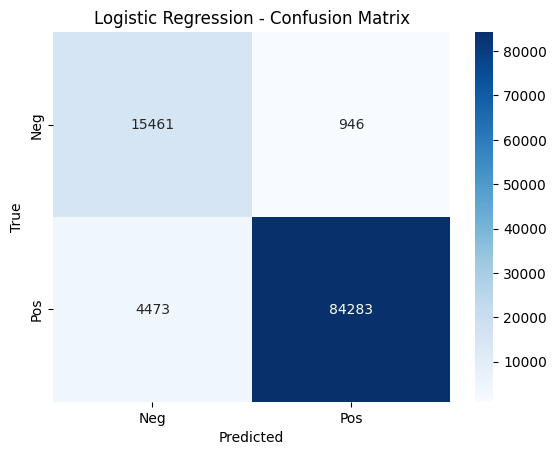

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Neg','Pos'], yticklabels=['Neg','Pos'])
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

In [35]:
y_proba = lr.predict_proba(X_test_tfidf)[:,1]
roc_auc = roc_auc_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)
precision, recall, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)


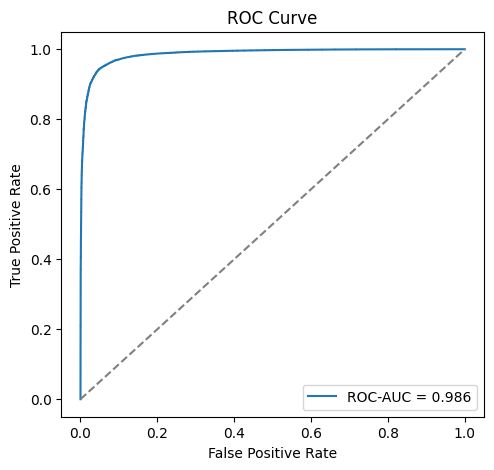

In [36]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()


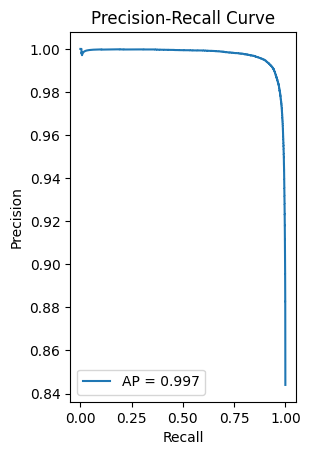

In [37]:
plt.subplot(1,2,2)
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


In [39]:
import pickle
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

with open("sentiment_model.pkl", "wb") as f:
    pickle.dump(lr, f)

print("sentiment_model.pkl and tfidf_vectorizer.pkl created!")

sentiment_model.pkl and tfidf_vectorizer.pkl created!
